## GRAPE With CNOT Example

In [ ]:
# ruff: noqa

"""
Gradient Ascent Pulse Engineering (GRAPE)
"""

import jax
import jax.numpy as jnp
import optax
from grape import optimize_pulse
from utils.gates import cnot
from utils.operators import identity, sigmax, sigmay, sigmaz
from utils.tensor import tensor

# TODO: Implement this with Pavlo's Cavity + Qubit coupled in dispersive regime

# Example usage
g = 0  # Small coupling strength
H_drift = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
H_ctrl = [
    tensor(sigmax(), identity(2)),
    tensor(sigmay(), identity(2)),
    tensor(sigmaz(), identity(2)),
    tensor(identity(2), sigmax()),
    tensor(identity(2), sigmay()),
    tensor(identity(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz()),
]

U_0 = identity(4)
# Target operator (CNOT gate)
C_target = cnot()

num_t_slots = 500
total_evo_time = 2 * jnp.pi

# Run optimization
result = optimize_pulse(
    H_drift,
    H_ctrl,
    U_0,
    C_target,
    num_t_slots,
    total_evo_time,
    max_iter=500,
    learning_rate=1e-2,
)
print("final_fidelity: ", result.final_fidelity)
print("U_f \n", result.final_operator)

In [ ]:
import matplotlib.pyplot as plt


def plot_control_amplitudes(times, final_amps, labels):
    num_controls = final_amps.shape[1]

    y_max = 0.1  # Fixed y-axis scale
    y_min = -0.1

    for i in range(num_controls):
        fig, ax = plt.subplots(figsize=(8, 3))

        for j in range(num_controls):
            color = (
                'black' if i == j else 'gray'
            )  # Highlight the current control
            alpha = 1.0 if i == j else 0.1
            ax.plot(
                times,
                final_amps[:, j],
                label=labels[j],
                color=color,
                alpha=alpha,
            )
        ax.set_title(f"Control Fields Highlighting: {labels[i]}")
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        ax.set_ylim(y_min, y_max)  # Set fixed y-axis limits
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


times = jnp.linspace(0, 2 * jnp.pi, 500)
H_labels = [
    r'$u_{1x}$',
    r'$u_{1y}$',
    r'$u_{1z}$',
    r'$u_{2x}$',
    r'$u_{2y}$',
    r'$u_{2z}$',
    r'$u_{xx}$',
    r'$u_{yy}$',
    r'$u_{zz}$',
]
plot_control_amplitudes(
    times, result.control_amplitudes / (2 * jnp.pi), H_labels
)

In [ ]:
U_target = cnot()
U_f = result.final_operator

In [ ]:
def overlap(U_target, U_f):
    """
    Calculate the overlap between the target unitary U_target and the final unitary U_f.

    Parameters:
    U_target (qutip.Qobj): Target unitary operator.
    U_f (qutip.Qobj): Final unitary operator.

    Returns:
    float: Real part of the overlap value.
    float: Fidelity (absolute square of the overlap).
    """
    # dividing over U_target.shape[0] is for normalization
    overlap_value = (
        jnp.trace(jnp.matmul(U_target.conj().T, U_f)) / U_target.shape[0]
    )
    fidelity = abs(overlap_value) ** 2
    return overlap_value.real, fidelity


# Example usage
overlap_real, fidelity = overlap(U_target, U_f)
print(f"Overlap (real part): {overlap_real}")
print(f"Fidelity: {fidelity}")

## GRAPE with time-dep

In [16]:
"""
Gradient Ascent Pulse Engineering (GRAPE)
"""

# ruff: noqa N8
import jax
import optax  # type: ignore
import optax.tree_utils as otu
from typing import NamedTuple
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
# TODO: Implement this with Pavlo's Cavity + Qubit coupled in dispersive regime
# TODO: remove side effects
# TODO: implement optimizer same as qutip_qtrl fmin_lbfgs or sth


class result(NamedTuple):
    control_amplitudes: jnp.ndarray
    final_fidelity: float
    iterations: int
    final_operator: jnp.ndarray


def _compute_propagators(
    H_drift,
    H_control_array,
    delta_t,
    control_amplitudes,
):
    """
    Compute propagators for each time step according to Equation (4).
    Args:
        H_drift: Drift Hamiltonian.
        H_control_array: Array of control Hamiltonians.
        delta_t: Time step for evolution.
        control_amplitudes: Control amplitudes for each time slot.
    Returns:
        propagators: Array of propagators for each time step.
    """
    num_t_slots = control_amplitudes.shape[0]

    # Compute each Uj according to Equation
    def compute_propagator_j(j):
        # Calculate total Hamiltonian for time step j
        H_0 = H_drift
        H_control = 0
        for k in range(len(H_control_array)):
            H_control += control_amplitudes[j, k] * H_control_array[k]

        H_total = H_0 + H_control

        U_j = jax.scipy.linalg.expm(-1j * delta_t * H_total)
        return U_j

    # Create an array of propagators
    propagators = jax.vmap(compute_propagator_j)(jnp.arange(num_t_slots))
    return propagators


def _compute_forward_evolution(propagators, U_0):
    """
    Compute the forward evolution states (ρⱼ) according to the paper's definition.
    ρⱼ = Uⱼ···U₁ρ₀U₁†···Uⱼ†

    Args:
        propagators: List of propagators for each time step.
        U_0: Initial density operator.
    Returns:
        rho_j: List of density operators for each time step j.
    """

    U_final = U_0
    for U_j in propagators:
        # Forward evolution
        # Use below if density operator is used
        # rho_final = U_j @ rho_final @ U_j.conj().T
        U_final = U_j @ U_final

    return U_final


def _init_control_amplitudes(num_t_slots, num_controls):
    """
    Initialize control amplitudes for the optimization process.
    Args:
        num_t_slots: Number of time slots.
        num_controls: Number of control Hamiltonians.
    Returns:
        init_control_amplitudes: Initialized control amplitudes.
    """
    # Random initialization
    # Here, you can't initialize with zeros, as it will lead to zero gradients
    # and no updates. Instead, use a small random value. (perhaps because of adam, but
    # TODO: use FMIN_L_BFGS_B instead of adam)
    key = jax.random.PRNGKey(42)
    return jax.random.uniform(
        key,
        (num_t_slots, num_controls),
        minval=-(2 * jnp.pi * 0.05),
        maxval=(2 * jnp.pi * 0.05),
    )


def _optimize_adam(
    _fidelity,
    control_amplitudes,
    max_iter,
    learning_rate,
    convergence_threshold,
):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(control_amplitudes)
    fidelities = []

    @jax.jit
    def step(params, state):
        loss = -_fidelity(params)  # Minimize -_fidelity
        grads = jax.grad(lambda x: -_fidelity(x))(params)
        updates, new_state = optimizer.update(grads, state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state, -loss

    params = control_amplitudes
    for iter_idx in range(max_iter):
        params, opt_state, current_fidelity = step(params, opt_state)
        fidelities.append(current_fidelity)

        if (
            iter_idx > 0
            and abs(fidelities[-1] - fidelities[-2]) < convergence_threshold
        ):
            print(f"Converged after {iter_idx} iterations.")
            break

        if iter_idx % 10 == 0:
            print(f"Iteration {iter_idx}, _fidelity: {current_fidelity}")
    final_fidelity = fidelities[-1]
    return params, final_fidelity, iter_idx


def _optimize_L_BFGS(
    _fidelity,
    control_amplitudes,
    max_iter,
    convergence_threshold,
):
    """
    Uses L-BFGS to optimize the control amplitudes.
    Args:
        _fidelity: Function to compute fidelity.
        control_amplitudes: Initial control amplitudes.
        max_iter: Maximum number of iterations.
        convergence_threshold: Convergence threshold for optimization.
    Returns:
        control_amplitudes: Optimized control amplitudes.
        fidelities: List of fidelity values during optimization.
    """

    def neg_fidelity(params, **kwargs):
        return -_fidelity(params, **kwargs)

    opt = optax.lbfgs()

    value_and_grad_fn = optax.value_and_grad_from_state(neg_fidelity)

    def step(carry):
        control_amplitudes, state, iter_idx = carry
        value, grad = value_and_grad_fn(control_amplitudes, state=state)
        updates, state = opt.update(
            grad,
            state,
            control_amplitudes,
            value=value,
            grad=grad,
            value_fn=neg_fidelity,
        )
        control_amplitudes = optax.apply_updates(control_amplitudes, updates)
        return control_amplitudes, state, iter_idx + 1

    def continuing_criterion(carry):
        _, state, _ = carry
        iter_num = otu.tree_get(state, 'count')
        grad = otu.tree_get(state, 'grad')
        err = otu.tree_l2_norm(grad)
        return (iter_num == 0) | (
            (iter_num < max_iter - 1) & (err >= convergence_threshold)
        )

    init_carry = (control_amplitudes, opt.init(control_amplitudes), 0)
    final_params, _, final_iter_idx = jax.lax.while_loop(
        continuing_criterion, step, init_carry
    )
    final_fidelity = _fidelity(final_params)
    return final_params, final_fidelity, final_iter_idx


# for unitary evolution (not using density operator)
def optimize_pulse(
    H_drift: jnp.ndarray,
    H_control: list[jnp.ndarray],
    U_0: jnp.ndarray,
    C_target: jnp.ndarray,
    num_t_slots: int,
    total_evo_time: float,
    max_iter: int = 1000,
    convergence_threshold: float = 1e-6,
    learning_rate: float = 0.01,
    type: str = "unitary",
    optimizer: str = "adam",
) -> result:
    """
    Uses GRAPE to optimize a pulse.

    Args:
        H_drift: Drift Hamiltonian.
        H_control: List of Control Hamiltonians.
        U_0: Initial density operator.
        C_target: Target operator.
        num_t_slots: Number of time slots.
        total_evo_time: Total evolution time.
        max_iter: Maximum number of iterations.
        convergence_threshold: Convergence threshold for _fidelity change.
        learning_rate: Learning rate for gradient ascent.
    Returns:
        result: Dictionary containing optimized pulse and convergence data.
    """
    # Step 1: Initialize control amplitudes
    control_amplitudes = _init_control_amplitudes(num_t_slots, len(H_control))
    delta_t = total_evo_time / num_t_slots

    # Convert H_control to array for easier manipulation
    H_control_array = jnp.array(H_control)

    def _fidelity(control_amplitudes):
        propagators = _compute_propagators(
            H_drift, H_control_array, delta_t, control_amplitudes
        )
        U_final = _compute_forward_evolution(propagators, U_0)

        if type == "unitary":
            overlap = (
                jnp.trace(jnp.matmul(C_target.conj().T, U_final))
                / C_target.shape[0]
            )
        else:
            # TODO: check accuracy of this, do we really need vector conjugate or .dot will simply work?
            norm_C_target = C_target / jnp.linalg.norm(C_target)
            norm_U_final = U_final / jnp.linalg.norm(U_final)

            overlap = jnp.vdot(norm_C_target, norm_U_final)
        return jnp.abs(overlap) ** 2

    # Step 2: Gradient ascent loop

    if optimizer.upper() == "L-BFGS":
        control_amplitudes, final_fidelity, iter_idx = _optimize_L_BFGS(
            _fidelity,
            control_amplitudes,
            max_iter,
            convergence_threshold,
        )
    else:
        control_amplitudes, final_fidelity, iter_idx = _optimize_adam(
            _fidelity,
            control_amplitudes,
            max_iter,
            learning_rate,
            convergence_threshold,
        )

    propagators = _compute_propagators(
        H_drift, H_control_array, delta_t, control_amplitudes
    )
    rho_final = _compute_forward_evolution(propagators, U_0)

    final_res = result(
        control_amplitudes,
        final_fidelity,
        iter_idx + 1,
        rho_final,
    )

    return final_res


def plot_control_amplitudes(times, final_amps, labels):
    """
    Plot control amplitudes with fixed y-axis scale highlighting each control
    amplitude with respect to the other in its respective plot.

    Args:
        times: Time points for the x-axis.
        final_amps: Control amplitudes to plot.
        labels: Labels for each control amplitude.
    """

    num_controls = final_amps.shape[1]

    # y_max = 0.1  # Fixed y-axis scale
    # y_min = -0.1

    for i in range(num_controls):
        fig, ax = plt.subplots(figsize=(8, 3))

        for j in range(num_controls):
            color = (
                'black' if i == j else 'gray'
            )  # Highlight the current control
            alpha = 1.0 if i == j else 0.1
            ax.plot(
                times,
                final_amps[:, j],
                label=labels[j],
                color=color,
                alpha=alpha,
            )
        ax.set_title(f"Control Fields Highlighting: {labels[i]}")
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        # ax.set_ylim(y_min, y_max)  # Set fixed y-axis limits
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

## Main.py

In [20]:
## MAIN.py with time_dep example

import jax
import qutip as qt
import numpy as np
import jax.numpy as jnp
import qutip_qtrl.pulseoptim as qtrl
from utils.gates import *
from utils.operators import *
from utils.tensor import tensor
from utils.states import basis
# ruff: noqa

N_cav = 10
chi = 0.2385 * (2 * jnp.pi)
mu_qub = 4.0
mu_cav = 8.0
hconj = lambda a: jnp.swapaxes(a.conj(), -1, -2)


@jax.vmap
def build_ham(e_qub, e_cav):
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)

    H_ctrl = mu_qub * sigp * e_qub + mu_cav * adag * e_cav
    H_ctrl += hconj(H_ctrl)
    # You just pass an array of the Hamiltonian matrices "Hs" corresponding to the time
    # intervals "delta_ts" (that is, "Hs" is a 3D array).
    return H0, H_ctrl


def build_grape_format_ham():
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    H_ctrl = [H_ctrl_qub, H_ctrl_qub_dag, H_ctrl_cav, H_ctrl_cav_dag]

    return H0, H_ctrl


def test_time_dep(optimizer="adam"):
    time_start = 0.0
    time_end = 1.0
    time_intervals_num = 5
    N_cav = 10
    t_grid = jnp.linspace(time_start, time_end, time_intervals_num + 1)
    delta_ts = t_grid[1:] - t_grid[:-1]
    fake_random_key = jax.random.key(seed=0)
    e_data = jax.random.uniform(
        fake_random_key, shape=(4, len(delta_ts)), minval=-1, maxval=1
    )
    e_qub = e_data[0] + 1j * e_data[1]
    e_cav = e_data[2] + 1j * e_data[3]
    H0, H_ctrl = build_ham(e_qub, e_cav)

    # Representation for time dependent Hamiltonian
    def solve(Hs, delta_ts):
        """
        Find evolution operator for piecewise Hs on time intervals delts_ts
        """
        for i, (H, delta_t) in enumerate(zip(Hs, delta_ts)):
            U_intv = jax.scipy.linalg.expm(-1j * H * delta_t)
            U = U_intv if i == 0 else U_intv @ U
        return U

    U = solve(H0 + H_ctrl, delta_ts)
    psi0 = tensor(basis(2), basis(N_cav))
    psi = U @ psi0

    H0_grape, H_ctrl_grape = build_grape_format_ham()

    res = optimize_pulse(
        H0_grape,
        H_ctrl_grape,
        psi0,
        psi,
        int(
            (time_end - time_start) / delta_ts[0]
        ),  # Ensure this is an integer
        time_end - time_start,
        max_iter=10000,
        # when you decrease convergence threshold, it is more accurate
        convergence_threshold=1e-3,
        learning_rate=1e-2,
        type="state",
        optimizer=optimizer,
    )
    return res

In [22]:
res = test_time_dep("l-bfgs")
print(res.final_fidelity)
print(res.iterations)

0.9977628731711521
105


In [23]:
time_start = 0.0
time_end = 1.0
time_intervals_num = 5

In [24]:
t_grid = jnp.linspace(time_start, time_end, time_intervals_num)

In [25]:
H_labels = [r'$u_1$', r'$u_2$', r'$u_3$', r'$u_4$', r'$u_5$']

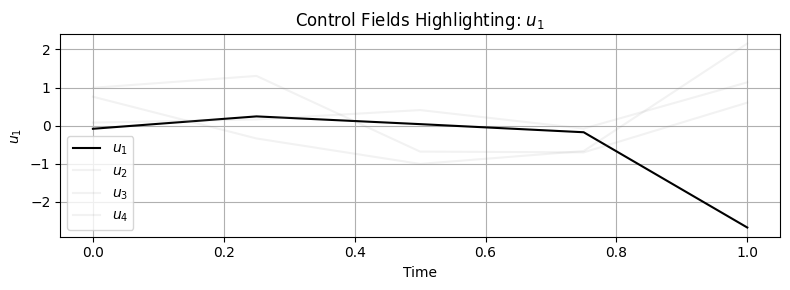

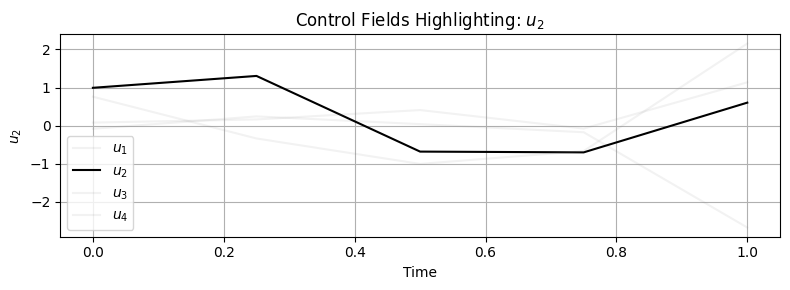

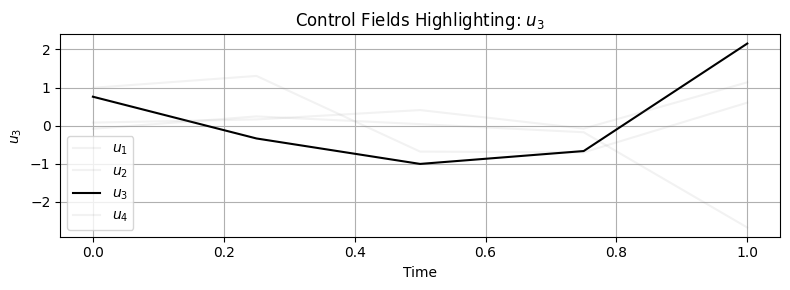

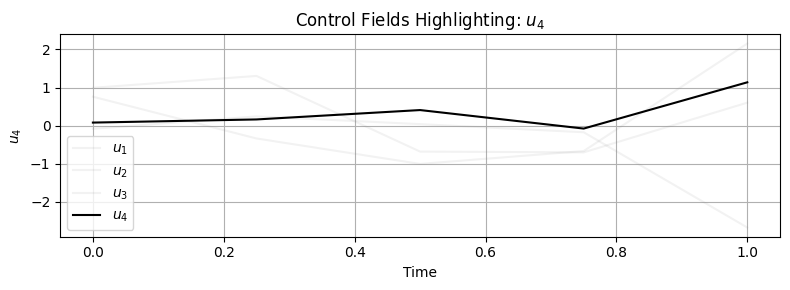

In [26]:
plot_control_amplitudes(t_grid, res.control_amplitudes, labels=H_labels)

## Tryng qutip's approach

In [27]:
N_cav = 10
chi = 0.2385 * (2 * jnp.pi)
mu_qub = 4.0
mu_cav = 8.0


def build_ham_qt(e_qub, e_cav):
    a = qt.tensor(qt.identity(2), qt.destroy(N_cav))
    adag = a.dag()
    n_phot = adag * a
    sigz = qt.tensor(qt.sigmaz(), qt.identity(N_cav))
    sigp = qt.tensor(qt.sigmap(), qt.identity(N_cav))
    one = qt.tensor(qt.identity(2), qt.identity(N_cav))

    H0 = +(chi / 2) * n_phot * (sigz + one)

    H_ctrl_qub = mu_qub * sigp
    H_ctrl_cav = mu_cav * adag

    H = [
        # time independent part
        H0,
        # time dependent on e_qub (you can consider e_qub an array of different coefficients each time step to
        # represent changing Hamiltonian with time)
        [H_ctrl_qub, e_qub],
        # time dependent on e_qub.conj()
        [H_ctrl_qub.dag(), e_qub.conj()],
        # time dependent on e_cav
        [H_ctrl_cav, e_cav],
        # time dependent on e_cav.conj()
        [H_ctrl_cav.dag(), e_cav.conj()],
    ]

    return H


# Here it is essential to have to use np.repeat, np.array else it will output coefficient format not understood
def test_time_dep_qt():
    # Constants in Hamiltonian

    time_start = 0.0
    time_end = 1.0
    time_intervals_num = 5
    psi0_qt = qt.tensor(qt.basis(2), qt.basis(N_cav))
    time_subintervals_num_qt = 100
    t_grid_qt = np.linspace(
        time_start, time_end, time_subintervals_num_qt * time_intervals_num
    )

    t_grid = np.linspace(time_start, time_end, time_intervals_num + 1)
    delta_ts = t_grid[1:] - t_grid[:-1]
    fake_random_key = jax.random.key(seed=0)
    e_data = jax.random.uniform(
        fake_random_key, shape=(4, len(delta_ts)), minval=-1, maxval=1
    )
    e_qub = e_data[0] + 1j * e_data[1]
    e_cav = e_data[2] + 1j * e_data[3]
    e_qub_qt = np.repeat(np.array(e_qub), time_subintervals_num_qt)
    e_cav_qt = np.repeat(np.array(e_cav), time_subintervals_num_qt)
    H_qt = build_ham_qt(e_qub_qt, e_cav_qt)
    psi_qt = qt.sesolve(H_qt, psi0_qt, t_grid_qt).states[-1]

    # Extract just the control operators from H_qt[1:] (not the coefficient arrays) (but that just completely discards the time dep part!)
    # However, it is weird, because the fidelity is quite high
    ctrls = [H_part[0] for H_part in H_qt[1:]]

    result = qtrl.optimize_pulse(
        H_qt[0],  # Drift Hamiltonian
        ctrls,  # Pass just the control operators
        psi0_qt,
        psi_qt,
        int(
            (time_end - time_start) / delta_ts[0]
        ),  # Ensure this is an integer
        time_end - time_start,
        max_iter=10000,
    )
    return result

In [28]:
res = test_time_dep_qt()

optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_va

In [29]:
1 - test_time_dep_qt().fid_err

optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_vals (20,)
ctrl_amps (5, 4)
optim_var_va

0.9837310714112759

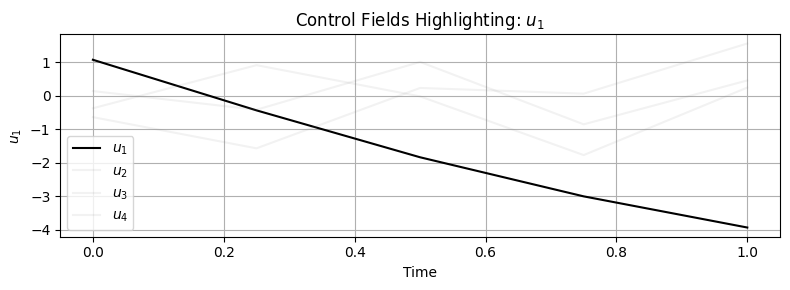

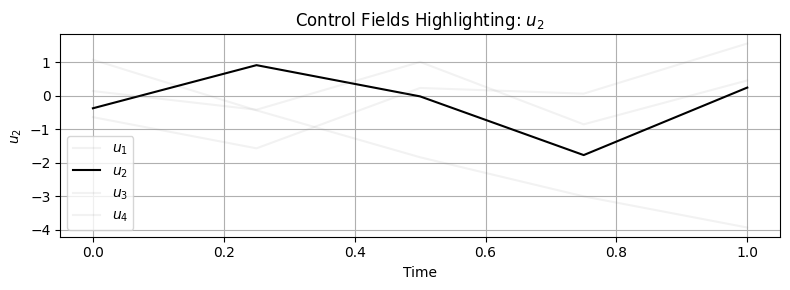

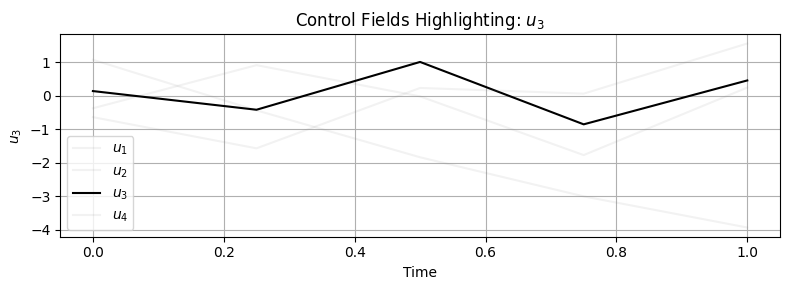

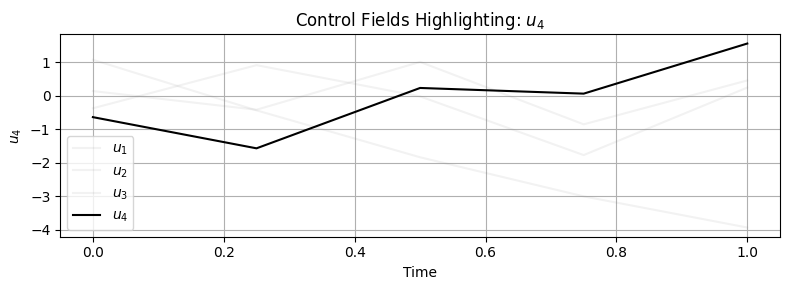

In [30]:
plot_control_amplitudes(t_grid, res.final_amps, labels=H_labels)